## 1: Setup of the environment

pyton module installation if necessary

In [ ]:
!pip install pandas
!pip install numpy
!pip install scipy
!pip install matplotlib

all imports

In [207]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.ndimage import gaussian_filter
from scipy import stats


Data reading and preparation

In [201]:
def timeToSec(x):
    m,s = x.split(':')
    return int(s) + (int(m)*60)
def loopOverSeries(x):
    return x.apply(lambda i: checkCoordinates(i))
def checkCoordinates(x):
    # print(x)
    if type(x) == type(' '):
        return list(map(int,x.split(' ')))
    elif type(x) == type([]):
        return x
    return []

#list of variables to test
variables = ['Task completion time','Total number of taps','Number of erroneous inputs']

#Read data from csv file
data = pd.read_csv('study_results.csv')

#convert task completion times in data from str to int (represented in secounds)
data['Task completion time'] = data['Task completion time'].apply(lambda x: timeToSec(x))

#fix empty coordinate representation in data
list_of_columns = ['Tap x coord.','Tap y coord.','Error x coord.','Error y coord.']
data[list_of_columns] = data[list_of_columns].apply(lambda x: (loopOverSeries(x)))

## 2: Heatmaps

Read all the touch and erroneous touch coordinates from data

In [114]:

# [ [list of x coord.] , [list of y coord.] ]
direct_tap = [[],[]]
direct_tap[0] = [x for sublist in data.loc[data['Task type'] == 'direct', 'Tap x coord.'] for x in sublist]
direct_tap[1] = [y for sublist in data.loc[data['Task type'] == 'direct', 'Tap y coord.'] for y in sublist]
indirect_tap = [[],[]]
indirect_tap[0] = [x for sublist in data.loc[data['Task type'] == 'indirect', 'Tap x coord.'] for x in sublist]
indirect_tap[1] = [y for sublist in data.loc[data['Task type'] == 'indirect', 'Tap y coord.'] for y in sublist]
direct_err = [[],[]]
direct_err[0] = [x for sublist in data.loc[data['Task type'] == 'direct', 'Error x coord.'] for x in sublist]
direct_err[1] = [y for sublist in data.loc[data['Task type'] == 'direct', 'Error y coord.'] for y in sublist]
indirect_err = [[],[]]
indirect_err[0] = [x for sublist in data.loc[data['Task type'] == 'indirect', 'Error x coord.'] for x in sublist]
indirect_err[1] = [y for sublist in data.loc[data['Task type'] == 'indirect', 'Error y coord.'] for y in sublist]

Plot the headmaps from the read data

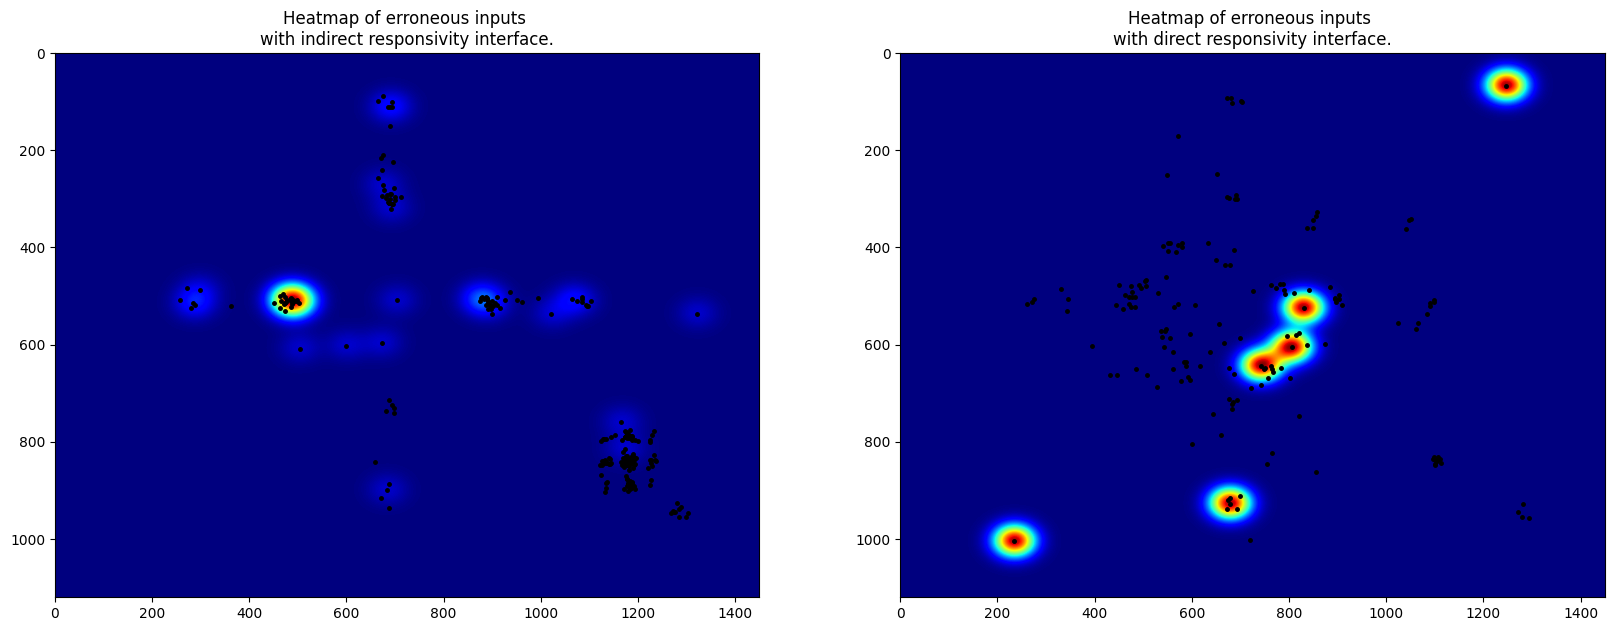

In [186]:
def heatmap(err, sigma, bins = 1000):
    heatmap, xedges, yedges = np.histogram2d(err[0], err[1], bins=bins, range=[[0,1450],[0,1120]])
    heatmap = gaussian_filter(heatmap, sigma=sigma)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

plt.figure(figsize=(20,40))
s = 20

#Heatmap of indirect variant
plt.subplot(221)
plt.plot(indirect_tap[0], indirect_tap[1], 'k.', markersize=5)
hMap1, extent1 = heatmap(indirect_err, s)
plt.imshow(hMap1, extent=extent1, origin='lower', cmap=cm.jet)
plt.title("Heatmap of erroneous inputs \nwith indirect responsivity interface.")
plt.gca().invert_yaxis()

#Heatmap of direct variant
plt.subplot(222)
plt.plot(direct_tap[0], direct_tap[1], 'k.', markersize=5)
hMap2, extent2 = heatmap(direct_err, s)
plt.imshow(hMap2, extent=extent2, origin='lower', cmap=cm.jet)
plt.title("Heatmap of erroneous inputs \nwith direct responsivity interface.")
plt.gca().invert_yaxis()

plt.show()

## 3: Properties of the data

### Plotting data

----------------------------------------------------------------------------------------------------
Statistics on task completion time
            mean        std        sem     ci95_hi     ci95_lo    y_error
Task type                                                                
direct     153.2  38.996154  17.439610  187.381636  119.018364  34.181636
indirect   145.6  25.055937  11.205356  167.562497  123.637503  21.962497
----------------------------------------------------------------------------------------------------
Statistics on total number of taps
           mean        std       sem    ci95_hi    ci95_lo    y_error
Task type                                                            
direct     33.6   8.876936  3.969887  41.380978  25.819022   7.780978
indirect   51.0  15.540270  6.949820  64.621647  37.378353  13.621647
----------------------------------------------------------------------------------------------------
Statistics on number of erroneous inputs
          

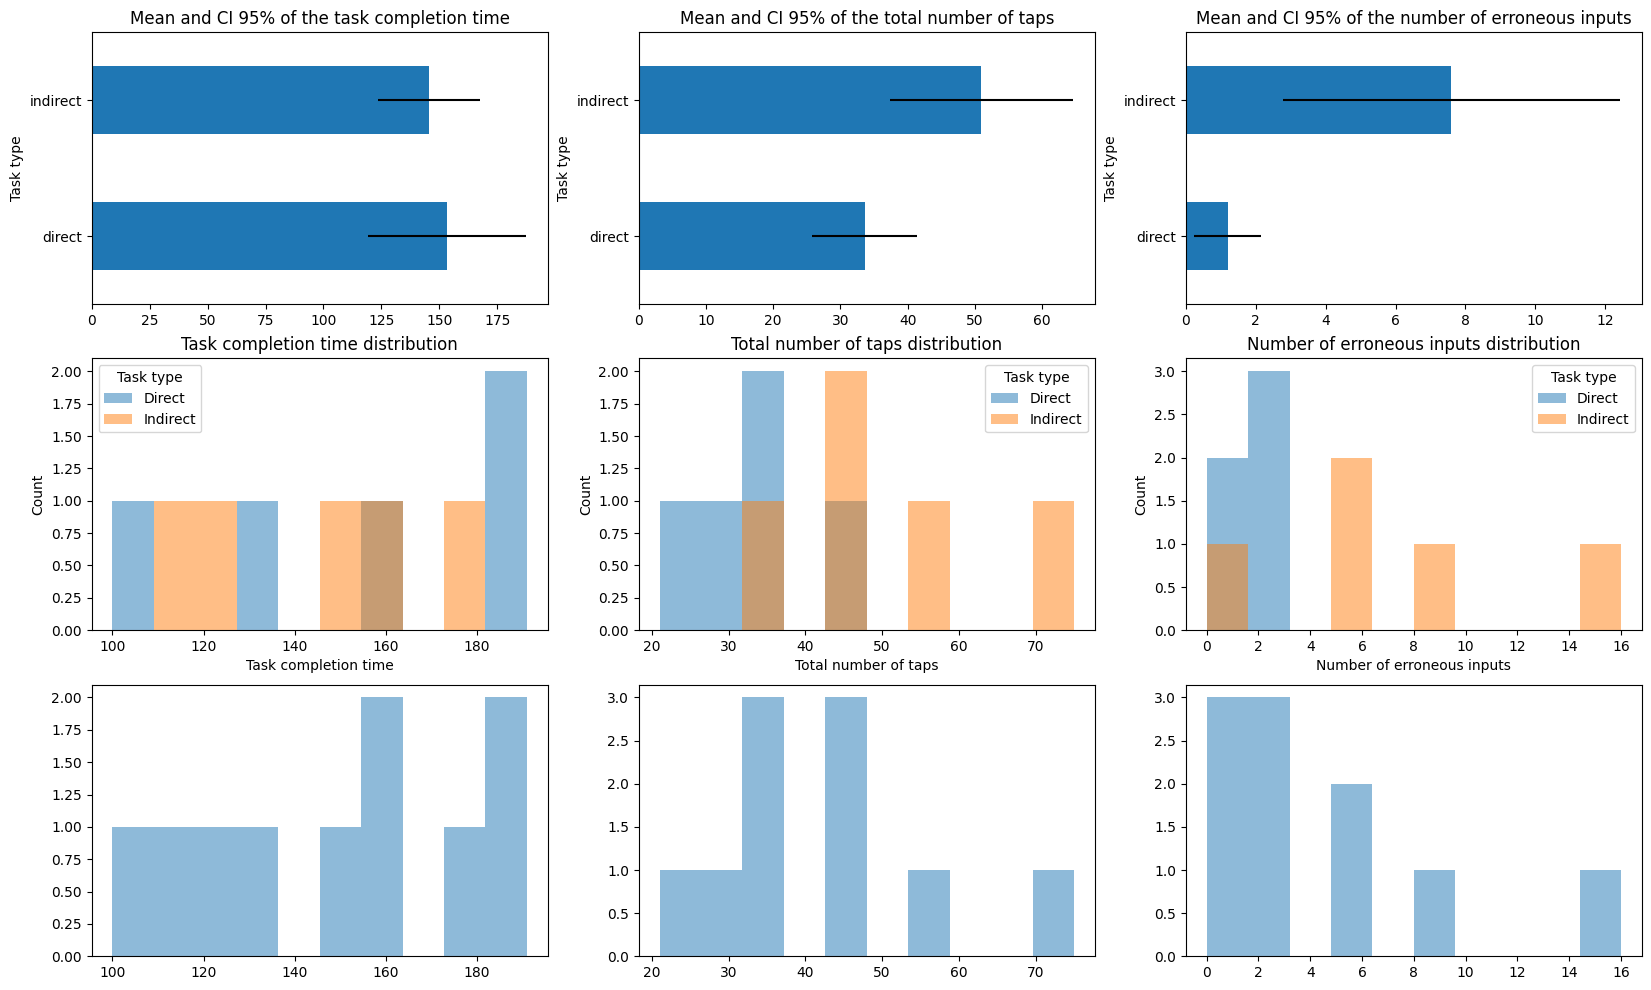

In [208]:
fig, axs = plt.subplots(3,3)
fig.set_size_inches(20,12)
print('-'*100)
for i in range(len(variables)):
    hist_min = data[variables[i]].min()
    hist_max = data[variables[i]].max()
    variable_stats = data.groupby(['Task type'])[variables[i]].agg(['mean', 'std', 'sem'])
    variable_stats['ci95_hi'] = variable_stats['mean'] + 1.96* variable_stats['sem']
    variable_stats['ci95_lo'] = variable_stats['mean'] - 1.96* variable_stats['sem']
    variable_stats['y_error'] = (variable_stats['ci95_hi'] - variable_stats['ci95_lo'])/2
    print("Statistics on "+ variables[i].lower())
    print(variable_stats)
    print('-'*100)

    variable_stats.plot(kind='barh',y = 'mean', legend= False, title="Mean and CI 95% of the "+variables[i].lower(),xerr="y_error", ax=axs[0,i])

    axs[1,i].hist(data.loc[data['Task type'] == 'direct', variables[i]], alpha=0.5, label='Direct',range=(hist_min,hist_max))
    axs[1,i].hist(data.loc[data['Task type'] == 'indirect', variables[i]], alpha=0.5, label='Indirect',range=(hist_min,hist_max))
    axs[1,i].set_title(variables[i]+' by interface type')
    axs[1,i].set_xlabel(variables[i])
    axs[1,i].set_ylabel('Count')
    axs[1,i].legend(title='Task type')
    axs[2,i].hist(data[variables[i]], alpha=0.5,range=(hist_min,hist_max))
    axs[1,i].set_title(variables[i]+' distribution')
    axs[1,i].set_xlabel(variables[i])
    axs[1,i].set_ylabel('Count')

#display plot
plt.show()

### Levene's and Shapiro-Wilk test

In [224]:
print("Normality and homoscedasticity tests on three our dependent variables:")
shapiro_tests = []
levene_tests = []
for x in variables:
    shapiro_tests.append(stats.shapiro(data[x]))
    levene_tests.append(stats.levene(data.loc[data['Task type'] == 'direct', variables[i]],data.loc[data['Task type'] == 'indirect', variables[i]]))
for i, x in enumerate(variables):
    print("\t"+x, end=': \n')
    print("\t\t", end="")
    print(shapiro_tests[i])
    print("\t\t", end="")
    print(levene_tests[i])

Normality and homoscedasticity tests on three our dependent variables:
	Task completion time: 
		ShapiroResult(statistic=0.9480875134468079, pvalue=0.6459303498268127)
		LeveneResult(statistic=2.1189189189189186, pvalue=0.1835806933056145)
	Total number of taps: 
		ShapiroResult(statistic=0.9238343238830566, pvalue=0.3900472819805145)
		LeveneResult(statistic=2.1189189189189186, pvalue=0.1835806933056145)
	Number of erroneous inputs: 
		ShapiroResult(statistic=0.8221288323402405, pvalue=0.026889005675911903)
		LeveneResult(statistic=2.1189189189189186, pvalue=0.1835806933056145)
